# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


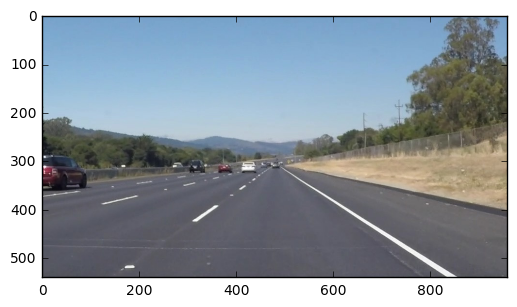

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
  
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    #Providing global access to the points belonging to the right and left least squares line for later use
    global right_line_x1,right_line_x2,left_line_x1,left_line_x2 
    
    #Initialising container lists for the points belonging to the left and right lines
    x1list_right,y1list_right,x2list_right,y2list_right = [],[],[],[]  
    x1list_left,y1list_left,x2list_left,y2list_left = [],[],[],[] 
    
    #Initialising the slopes belonging to the left and right lines
    slopes_r,slopes_l = [],[]
    lines_right,lines_left = [],[]
    
    #Iterating through lines found by the hough transform method
    #The iterator line and the container lines are nested lists
    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
        #To avoid zero division
        if x2-x1==0:
            m=0
        #Note: The slopes are inverted because of how images are plotted in image processing         
        
        #Positive slopes for Right lines
        if m>0:
        #Subsetting slopes between a slower slope of 0.3(almost horizontal) and a faster slope of 10(almost vertical)      
            if m>0.3 and m<10:    
                slopes_r.append(m)
                lines_right.append([[x1,y1,x2,y2]]) 
        #Negative slopes for Left lines  
        elif m<0:
            if m<-0.3 and m>-10 :
                slopes_l.append(m)
                lines_left.append([[x1,y1,x2,y2]])
                
    #Unpacking the lines to points

    #Unpacking the points belonging to the right line
    for line in lines_right:
        for x1,y1,x2,y2 in line:        
            x1list_right.append(x1)
            y1list_right.append(y1)
            x2list_right.append(x2)
            y2list_right.append(y2)
        
    #Unpacking the points belonging to the left line
    for line in lines_left:
        for x1,y1,x2,y2 in line:        
            x1list_left.append(x1)
            y1list_left.append(y1)
            x2list_left.append(x2)
            y2list_left.append(y2)
    
    #Plotting the points on the image for the left and right lines
    #Uncomment to view the points
    #plt.scatter(x1list_right+x2list_right,y1list_right+y2list_right)
    #plt.scatter(x1list_left+x2list_left,y1list_left+y2list_left)
    
    '''When the final(weighted) image is generated, it can be seen that the points that fall on the lanes show a trend
    The trend can be represented by least squares lines for left and right for which the slopes and the intercepts
    are calculated below'''
    
    #Finding the least squares line for the right lane
    
    #Calculating the mean of the coordinates on the right line    
    x_list_right = x1list_right+x2list_right
    y_list_right = y1list_right+y2list_right
    mean_x = np.mean(x_list_right)
    mean_y = np.mean(y_list_right)
    #Calculating the sum of errors in x and y for the righ line
    errors_x = np.array(x_list_right)-mean_x  
    error_sum_x = sum(errors_x)
    errors_y = np.array(y_list_right)-mean_y  
    error_sum_y = sum(errors_y)  
    #Calculating sum of errors squared in x
    error_sum_squares_x = sum(errors_x*errors_x)    
    #To avoid division by zero further       
    if error_sum_squares_x==0:
        error_sum_squares_x = 1
    #Calculating the slope and intecept for the right least squares line    
    best_slope_right = sum(errors_x*errors_y)/error_sum_squares_x    
    best_intercept_right = mean_y-(best_slope_right*mean_x)
    
    
    
    #Finding the least squares line for the left lane
                   
    #Calculating the mean of the coordinates on the left line    
    x_list_left = x1list_left+x2list_left
    y_list_left = y1list_left+y2list_left
    mean_x_l = np.mean(x_list_left)
    mean_y_l = np.mean(y_list_left)
    #Calculating the sum of errors in x and y
    errors_x_l = np.array(x_list_left)-mean_x_l  
    error_sum_x_l = sum(errors_x_l)
    errors_y_l = np.array(y_list_left)-mean_y_l  
    error_sum_y_l = sum(errors_y_l)  
    #Calculating sum of errors squared in x
    error_sum_squares_x_l = sum(errors_x_l*errors_x_l)        
    #To avoid division by zero further    
    if error_sum_squares_x_l==0:
        error_sum_squares_x_l = 1     
    #Calculating the slope and intecept for the left least squares line    
    best_slope_left = sum(errors_x_l*errors_y_l)/error_sum_squares_x_l   
    best_intercept_left = mean_y_l-(best_slope_left*mean_x_l)
    
    
    
    #As the height of the mask is 330, so y2 of the lines is 330 and the y1 of the line is 540(image.shape[0])
    
    #Finding the x1 and x2 for the right least squares line
    right_line_x1 = (img.shape[0] - best_intercept_right) / best_slope_right
    right_line_x2 = (330 - best_intercept_right) / best_slope_right
    #Finding the x1 and x2 for the left least squares line
    left_line_x1 = (img.shape[0] - best_intercept_left) / best_slope_left
    left_line_x2 = (330 - best_intercept_left) / best_slope_left
    

    
    #Rejecting zero division least squares right lines
    if error_sum_squares_x != 1:
        cv2.line(img, (int(right_line_x1), img.shape[0]), (int(right_line_x2), 330), [20,255,20], 4)
    
    #Rejecting zero division least squares left lines   
    if error_sum_squares_x_l != 1:    
        cv2.line(img, (int(left_line_x1), img.shape[0]), (int(left_line_x2), 330), [20,255,20], 4)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    a = draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)




## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'whiteCarLaneSwitchT.jpg']

run your solution on all test_images and make copies into the test_images directory).

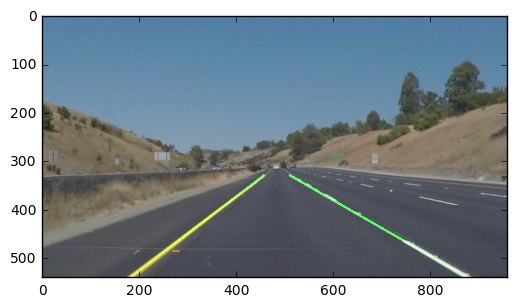

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
image = mpimg.imread('test_images/whiteCarLaneSwitch.jpg')
grayscale_output = grayscale(image)
blurred_image = gaussian_blur(grayscale_output,5)
edges = canny(blurred_image,50,150)
imshape = image.shape
vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
masked_output = region_of_interest(edges,vertices)
hough_image = hough_lines(masked_output,2,np.pi/180,40,10,20)
final_output = weighted_img(hough_image,image)
figure = plt.imshow(final_output)
plt.savefig('test_images/whiteCarLaneSwitchT.jpg')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [6]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [7]:
#Defining container lists to capture 'right_line_x1','right_line_x2','left_line_x1','left_line_x2'
new_right_x1_y1,new_right_x2_y2,new_left_x1_y1,new_left_x2_y2 = [],[],[],[] 

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    
    ''' 
    The process_image( ) method returns a single image output, the final video is just the outcome of 
    multiple iterations of the process_image( ) method. 
    
    We use 'right_line_x1','right_line_x2','left_line_x1','left_line_x2' each frame processed and populate
    the corresponding container lists. 
    
    We then determine the averages at every thirty points collected and assign them to:
    avg_right_x1,avg_right_x2,avg_left_x1,avg_left_x2
    
    The final stabilised tracking lines are represented by the coordinates:
    (avg_right_x1,540),(avg_right_x2,330) and (avg_left_x1,540),(avg_left_x2,330)
    
    Therfore, the final lines are just the averaged least squares lines(right and left) of each frame.
    '''
    
    #for allowing the method to access the lists
    global new_right_x1_y1,new_right_x2_y2,new_left_x1_y1,new_left_x2_y2 
    
    #Initialising the averaged values of the coordinates of the right and left least squares lines
    avg_right_x1,avg_right_x2 = 0,0
    avg_left_x1,avg_left_x2 = 0,0
    
    #Converting to grayscale colorspace
    grayscale_output = grayscale(image)
    blurred_image = gaussian_blur(grayscale_output,7)
    edges = canny(blurred_image,50,150)
    
    #Defining a static mask
    imshape = image.shape
    vertices = np.array([[(0,imshape[0]),(450, 330), (490, 330), (imshape[1],imshape[0])]], dtype=np.int32)
    masked_output = region_of_interest(edges,vertices)
    hough_image = hough_lines(masked_output,2,np.pi/180,20,5,10)
    
    #Capturing 'right_line_x1','right_line_x2','left_line_x1','left_line_x2' in their container lists 
    new_right_x1_y1.append(right_line_x1)
    new_right_x2_y2.append(right_line_x2)
    new_left_x1_y1.append(left_line_x1)                           
    new_left_x2_y2.append(left_line_x2)                    
    
    #Taking average at every thirty samples, when the list posseses more than thirty samples discard everything other than 
    #the last thirty values - For controlling the bias by old values and keeping a limited size for faster computation.
    avg_right_x1 = np.mean(new_right_x1_y1)
    if len(new_right_x1_y1)>30:
        new_right_x1_y1 = new_right_x1_y1[-30:]
        avg_right_x1 = np.mean(new_right_x1_y1)
         
    avg_right_x2 = np.mean(new_right_x2_y2)
    if len(new_right_x2_y2)>30:
        new_right_x2_y2 = new_right_x2_y2[-30:]
        avg_right_x2 = np.mean(new_right_x2_y2)
    
    avg_left_x1 = np.mean(new_left_x1_y1)
    if len(new_left_x1_y1)>30:
        new_left_x1_y1 = new_left_x1_y1[-30:]
        avg_left_x1 = np.mean(new_left_x1_y1)
    
    avg_left_x2 = np.mean(new_left_x2_y2)
    if len(new_left_x2_y2)>30:
        new_left_x2_y2 = new_left_x2_y2[-30:]
        avg_left_x2 = np.mean(new_left_x2_y2)
    
    
    #Initialising a blank black canvas of the same dimensions as the image
    black_img = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.uint8)
    
    #To avoid calling int() on NaN values
    if math.isnan(avg_right_x1) != True or math.isnan(avg_right_x2) != True:
        #Drawing the averaged right line on black_img
        rightGuideLine = cv2.line(black_img, (int(avg_right_x1), image.shape[0]), (int(avg_right_x2), 330), [255,0,0], 8)
    
    if math.isnan(avg_left_x1) != True or math.isnan(avg_left_x2) != True:
        #Drawing the averaged left line on black_img
        leftGuideLine = cv2.line(black_img, (int(avg_left_x1), image.shape[0]), (int(avg_left_x2), 330), [255,0,0], 8)
    
    #Final output is a blend of black_img and each frame(image) of the input video 
    final_output = cv2.addWeighted(image,0.8,black_img, 1, 0.)
    result = final_output
    return result    

Let's try the one with the solid white lane on the right first ...

In [8]:
#Resetting the container lists
new_right_x1_y1,new_right_x2_y2,new_left_x1_y1,new_left_x2_y2 = [],[],[],[] 

white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:02<00:00, 89.16it/s]     | 12/222 [00:00<00:01, 112.90it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 2.17 s, sys: 558 ms, total: 2.72 s
Wall time: 2.86 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [9]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [10]:
#Resetting the container lists
new_right_x1_y1,new_right_x2_y2,new_left_x1_y1,new_left_x2_y2 = [],[],[],[] 

yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:08<00:00, 77.48it/s]     | 10/682 [00:00<00:06, 96.81it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 7.54 s, sys: 1.79 s, total: 9.33 s
Wall time: 9.24 s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### Notes and reflections:

####    1.) On Masking Technique:

    The mask used here is a fixed mask(fixed vertices), it can only work in a handful of conditions. 
    The mask vertices could be made dynamic based on the detection of the horizon where the visible end of the 
    road and the surroundings meet. The dynamic mask can improve the performace of lane tracking as the level
    of the horizon can vary from situation to situation. 
    
    The hough transform output is also affected by the region and dimensions of the mask. The tighter the mask is,
    the better the output.
    
    Also, controlling the region and the dimensions of the mask can be used improve the computation times of each
    frame in the input video/camera feed. As masking out unnecessary regions will allow the algorithm to process
    only the relevant data.
   
####    2.) On Straight Lane Tracking and Detection:
    
    The current algorithm only allows us to detect lanes percieved as straight lines only. The algorithm can be
    improved if lane curves could be detected. 
    
    The current cases only cover the scenarios with neatly marked lanes under good visibility condtions. 
    Worn out lane markings on the road can lead to erronuous detections.
    
####     3.) On Tracking Line Stability:

    The raw/unstabilised tracking lines can be extremely shaky in nature. To reduce the shake, a better approach
    could be used. The current approach will perform poorly when the lanes are suddenly changed by the vehicle as it
    averages the coordintes. 


####     4.) Observations from the optional challenge: 
    
    a.)the lanes are curved ;the above algorithm only detects straight lines 
    
    b.)the horizon is skewed to right due to the curved nature of the road; the current algorithm treats the leading
       lines as straight lines only.
       
    c.)the vehicle edge is significantly visible; the canny edge detector output gets adversly affected by the 
       edge of the vehicle.
       
    d.)sporadic changes in lighting conditions; at around 4s in the third video when sunlight becomes significantly
       visible on the road, the algorithm fails to find the lane marking.
       
    e.)color of the asphalt/roach patches; the color changes(patches) in roads can also affect the detection 
       process. 


## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [12]:
#Resetting the container lists
new_right_x1_y1,new_right_x2_y2,new_left_x1_y1,new_left_x2_y2 = [],[],[],[] 
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:07<00:00, 33.38it/s]     | 5/251 [00:00<00:05, 42.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 6.19 s, sys: 1.23 s, total: 7.42 s
Wall time: 8.35 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))